## Imports

In [1]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
import matplotlib.pyplot as plt


import numpy as np
# from tqdm import tqdm
import scipy
from scipy.optimize import minimize, basinhopping
import optuna
import os
from pathlib import Path
import skvideo.io
import IPython

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt
import numpy as np
def fig2np(fig):
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    return np.array(canvas.buffer_rgba())

%matplotlib inline

/home/daniel/anaconda3/envs/mthesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data (of a single time slice)

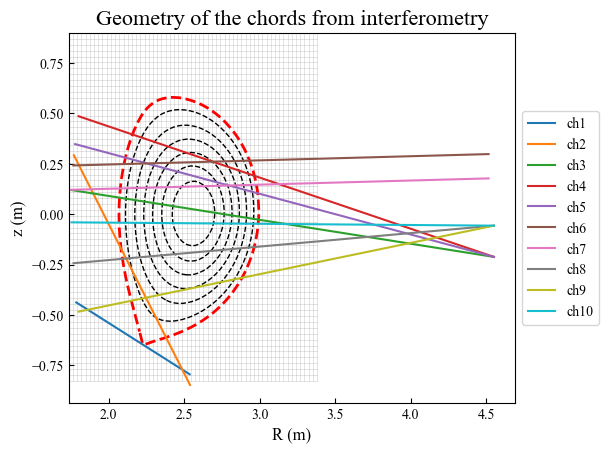

In [2]:
shot = 53259 # Shot number
t = 5.21    # Time (relative to the start of plasma)

# Geometry of the chords from interferometer (lines of sight)
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

# Magnetic equilibrium calculated by equilibrium code NICE
equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

# Line integrated electron density measured by interferometer
interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

# Density profile calculated by equilibrium code NICE, to be used to generate synthetic data
dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

## Plotting The NICE profile and vrious Data Options

The responce martix is applied to the NICE profile to generate ground truth data for a simulation where NICE is the exact profile in the TOKAMAK.

Some noise is added to the ground truth data to generate synthetic data.

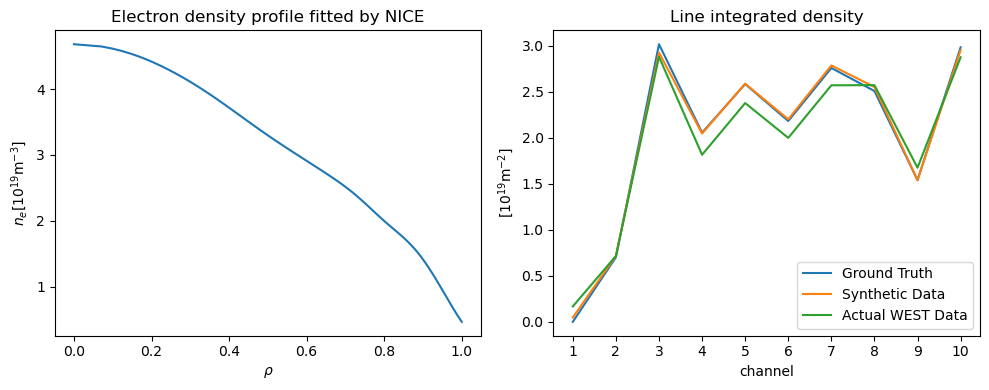

In [3]:
EXP_ER = 0.03 #background noise order of magnitude
M = len(interf.channels.compressed()) #number of channels 
def data_gen(prof_1d, R):
    lid_true = R @ prof_1d
    lid_data = lid_true + np.random.normal(loc=0, scale=EXP_ER, size=len(lid_true))
    return lid_true, lid_data
                                          
# The response matrix used for calculating line integrals
R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)

lid_true, lid_data = data_gen(dens_prof.dens_1d,R)                                           

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
nice = dens_prof.dens_1d
ax1.plot(dens_prof.rho_tor_norm_1d, dens_prof.dens_1d)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$n_e[\mathrm{10^{19} m^{-3}}]$')
ax1.set_title('Electron density profile fitted by NICE')

ax2.plot(interf.channels.compressed(), lid_true, label='Ground Truth')
ax2.plot(interf.channels.compressed(), lid_data, label='Synthetic Data')
ax2.plot(interf.channels.compressed(), interf.lid.compressed(), label='Actual WEST Data')

ax2.set_xticks(interf.channels.data)
ax2.set_xlabel('channel')
ax2.set_ylabel(r'$[\mathrm{10^{19} m^{-2}}]$')
ax2.set_title('Line integrated density')
ax2.legend()
plt.tight_layout()





# Setting Data

In [4]:
rho_1d = dens_prof.rho_tor_norm_1d

# Ground Trueth. Assuming a profile is true what is the exact LID for each channel?
# lid_d = lid_true
# Synthetic data, gaussian noise added to ground truth
lid_d = lid_data
# Real Data for each channel from west
# lid_d = interf.lid.compressed()


# Static OR non-Static Kernel

In [62]:
STATIC = 3
# 1 means completly static
# 2 means static amp but non static length-scale
# 3 means static amp but non static length-scale with a hyperbolic tangent functional form 
# 4 means static amp but non static length-scale with a exonential decay functional form 
# 5 means non static length scale and amp

if STATIC==1:
    def Kernel(rho_test,params):
        RHOA, RHOB = np.meshgrid(rho_test,rho_test)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = params[1]
        return amp**2 * np.ones((len(rho_test),len(rho_test)))* np.exp(-((RHOA-RHOB)*(RHOA-RHOB))/(2*l**2))
    initial_params = [4.48730023, 0.91623679]#[20,0.1]
    # initial_params = [5.62,1.37]
    # initial_params = [5.62,10]
elif STATIC==2:
    def Kernel(rho_test,params):
        RHOA, RHOB = np.meshgrid(rho_test,rho_test)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = np.array(params[1:])
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_test)))    
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    #initial_params = ([5.62]+list(np.repeat(10,3))+list(np.repeat(1.37,len(rho_test)-3)))
    initial_params = ([5.62]+list(np.repeat(1.37,len(rho_test))))
    #exponential decay of correlation length. Creates a flat area at 0.
    # l_initial = list(10*np.exp(-2*rho_test))
    # initial_params = ([5.62]+l_initial)
    # plt.plot(rho_test,l)

elif STATIC==3:
    def Kernel(rho_test,params, plot=False):
        RHOA, RHOB = np.meshgrid(rho_test,rho_test)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        def HyperTan_l(rho, params):
            core_l, edge_l, transition_center, transition_width = params[1:]
            return ((core_l + edge_l)/2) - (((core_l - edge_l)/2) * np.tanh((rho - transition_center)/transition_width))
        l = HyperTan_l(rho_test, params)
        if plot: plt.plot(rho_test,l)
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_test)))
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    initial_params = ([4, 0.91, 0.01, 0.9, 0.05])#([ 30.46490307,   1.26607835, -12.65929225,   1.30549892, 0.18071757])#([5.62,2,0.1,0.7,0.1])
    
elif STATIC==4:
    def Kernel(rho_test,params):
        RHOA, RHOB = np.meshgrid(rho_test,rho_test)
        #amplitude determins how far the model can go from the mean
        amp = params[0]
        #length scale determines smoothness, how correlated the function should be at a distance
        core_l, edge_l, drop_rate = params[1:]
        def ExpDecay_l(rho):
            return core_l * np.exp(-drop_rate*rho) + edge_l
        l = ExpDecay_l(rho_test)
        plt.plot(rho_test,l)
        LA, LB = np.meshgrid(l,l)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2) + np.diag(np.repeat(1e-8,len(rho_test)))
        return amp * np.sqrt(frac) * np.exp(-(mag/scale2))
    #large l for first three 
    #initial_params = ([5.62]+list(np.repeat(10,3))+list(np.repeat(1.37,len(rho_test)-3)))
    
    initial_params = ([5.62,10,1,9])

    
elif STATIC==5:
    def Kernel(rho_test,params):
        RHOA, RHOB = np.meshgrid(rho_test,rho_test)
        #amplitude determins how far the model can go from the mean
        amp = params[:N]
        #length scale determines smoothness, how correlated the function should be at a distance
        l = np.array(params[N:])
        LA, LB = np.meshgrid(l,l)
        AMPA, AMPB = np.meshgrid(amp,amp)
        mag = (RHOA - RHOB) * (RHOA - RHOB)
        scale1 = 2 * LA * LB
        scale2 = (LA * LA) + (LB * LB)
        frac = (scale1/scale2)    
        return (3*AMPA*AMPB / AMPA*AMPA+AMPB*AMPB) * frac * np.exp(-(mag/scale2))
    # initial_params = list(np.repeat(5.62,N))+list(np.repeat(1.37,N))
    initial_params = list(np.repeat(5.62,N))[:-1]+[0.5]+list(np.repeat(1.37,N))


Kernel(rho_1d, initial_params)
a=1

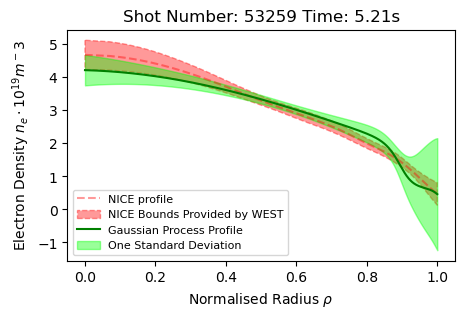

In [63]:
class ForwardGPR(object):
    def __init__(self, rho_test, lid_d, lid_error, Kernel, initial_params, prior_mu):
        self.rho_test = rho_test
        self.lid_d = lid_d
        self.initial_params = initial_params
        self.prior_mu = prior_mu
        self.lid_error = lid_error
        
        self.post_mu = None
        self.post_cov = None
        self.best_params=None
        self.best_marge_li = None
    def chol_inv(self, A):
        L = np.linalg.cholesky(A)
        return np.linalg.inv(L).T @ np.linalg.inv(L)
    def chol_det(self, A):
        L = np.linalg.cholesky(A)
        return np.prod(np.diag(L))

    def KRcov_li(self, params):
        #covergence matrix of Prior
        K = Kernel(self.rho_test, params)
        #add a small term onto diagonal of matricies to be inverted.
        #this ensures it is positive definate and cholensky matrix can be computed
        K[np.diag_indices_from(K)] += 1e-8 
        #covergence matrix of Likelyhood
        cov_li = np.diag(self.lid_error) # M is number of channels
        R = compute_response_matrix(geo, equi, self.rho_test)
        return K, R, cov_li

    def MargLi(self, params):
        K, R, cov_li = self.KRcov_li(params)
        invertable = cov_li + R @ K @ R.T
        #add a small term onto diagonal of matricies to be inverted.
        #this ensures it is positive definate and cholensky matrix can be computed
        invertable[np.diag_indices_from(invertable)] += 1e-8
        if np.isinf(invertable).any() or np.isnan(invertable).any():
            print('matrix has an inf or nan with causes issues for square root, reurning inf for marginal likelihood')
            return float('inf')
        elif np.any(np.linalg.eigvals(invertable) <= 0):
            print('Matrix is not positive definate, returning inf for marginal likelyhood')
            return float('inf')
        return marge_li
    
    def Fit(self, method=None):
        if method=='basinhopping':
            results = basinhopping(self.MargLi, x0=initial_params, niter=100)
        else: results = minimize(self.MargLi, x0=initial_params)
        print("\n\nFIT RESULTS\n",results)
        self.best_params = results.x
        self.best_marge_li = MargLi(best_params)
    
    def Infer(self, params):
        K, R, cov_li = self.KRcov_li(params)
        self.post_cov = self.chol_inv(R.T @ self.chol_inv(cov_li) @ R + self.chol_inv(K))
        self.post_mu = self.prior_mu + self.post_cov @ R.T @ self.chol_inv(cov_li) @ (self.lid_d - R @ self.prior_mu)
        
#         print('\n\nNot good if zero, as need to be chol_inverted.')
#         print('The Determinent of K is:', self.chol_det(K))
#         print('The Determinent of cov_li is:', self.chol_det(cov_li))
#         print('The Determinent of cov_post3 is:', self.chol_det(self.post_cov))
        
    def PlotInference(self): 
        std = np.sqrt(np.diagonal(self.post_cov))

        figGPR3 = plt.figure(figsize=(5,3))
        plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
        plt.xlabel(r'Normalised Radius $\rho$')
        plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^-3$')
        plt.plot(rho_1d, nice,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
        plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
        plt.plot(rho_test, self.post_mu,'g', label='Gaussian Process Profile')
        plt.fill_between(rho_test, self.post_mu-std, self.post_mu+std, color=(0,1,0,0.4),linestyle='-',label='One Standard Deviation')
        plt.legend(fontsize = 8)
        plt.show()

# def parabola(rho):
#     return 4.9*(1-rho**2)
# prior_mu = np.zeros(N)#parabola(rho_test)#np.zeros(N)#dens_prof.dens_1d#
#exponential square kernel

N=1000#101
rho_test=np.linspace(0,1,N)
prior_mu=np.zeros(N)
interf = ForwardGPR(rho_test=rho_test, lid_d=lid_d, lid_error=np.repeat(EXP_ER,M), Kernel=Kernel, initial_params=initial_params, prior_mu=prior_mu)
# interf.Fit(method='basinhopping')
# interf.Fit()
# interf.Infer(interf.best_params)
interf.Infer(interf.initial_params)
interf.PlotInference()

In [48]:
interf.best_params

array([4.48730023, 0.91623679])

In [ ]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 10)
    l = trial.suggest_float('l', 0, 0.2)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

# Full pipeline, Forward GPR with Vanilla GRP to add edge and gradient information then optimising the initial kernel parameters

None detected, returning inf
None detected, returning inf
None detected, returning inf
None detected, returning inf
None detected, returning inf
None detected, returning inf


FIT RESULTS
       fun: inf
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([nan, nan, nan, nan, nan])
  message: 'NaN result encountered.'
     nfev: 6
      nit: 0
     njev: 1
   status: 3
  success: False
        x: array([4.  , 0.91, 0.01, 0.9 , 0.05])


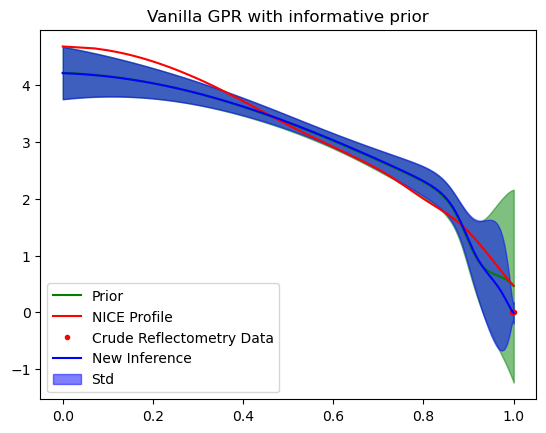

None detected, returning inf


inf

In [75]:

def FullPipeMargeLi(params, plot=False):
    N=1000
    rho_test=np.linspace(0,1,N)
    prior_mu=np.zeros(N)
    interf = ForwardGPR(rho_test=rho_test, lid_d=lid_d, lid_error=np.repeat(EXP_ER,M), Kernel=Kernel, 
                        initial_params=params, prior_mu=prior_mu)
    interf.Infer(interf.initial_params)
    marge_li_interf = interf.best_marge_li
    prior_cov = interf.post_cov
    prior_mu = interf.post_mu
    add_artif_obvs = InformativeGradientVanillaGPR(x_test=rho_test, xd=np.array([1,0.999,0.998,0.997]), yd=np.array([0,0,0,0]),
                    yd_noise=np.array([0.1,0.1,0.1,0.1]), prior_mu=prior_mu, prior_cov=prior_cov,
                    xd_prime=np.array([0,0.001,0.002,0.003]), yd_prime=np.array([0,0,0,0]), yd_prime_noise=np.array([0.1,0.1,0.1,0.1]))
    
    add_artif_obvs.Infer()
    if plot: add_artif_obvs.PlotInference()
    marge_li_artif_obvs = add_artif_obvs.marge_li
    if marge_li_interf == None or marge_li_artif_obvs == None:
        print("None detected, returning inf")
        return float('inf')
    marge_li_combi = marge_li_interf + marge_li_artif_obvs
    return marge_li_combi

# results = basinhopping(FullPipeMargeLi, x0=initial_params, niter=100)
results = minimize(FullPipeMargeLi, x0=initial_params)
print("\n\nFIT RESULTS\n",results)
best_params = results.x

FullPipeMargeLi(best_params, plot=True)




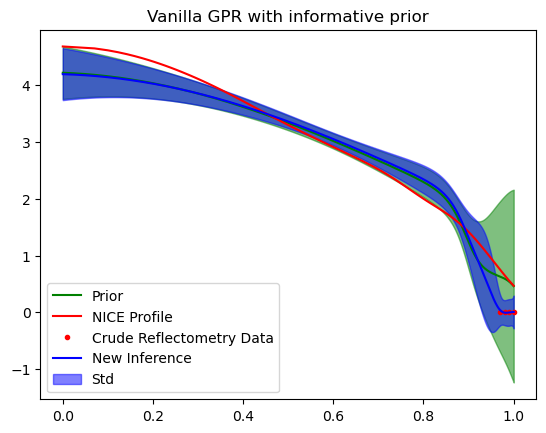

None detected, returning inf


inf

In [74]:

FullPipeMargeLi(best_params, plot=True)


# Including Potential Reflectometry Data

If I get reflectometry data I can use vanilla GPR with the prior being the posterior from forward model GPR. Here is me testing that pipeline. I suspect I can do something similar to include arificial observations.

## Informative Prior Vanilla GPR with or without Gradient Information

This can take a prior and insert it into vanilla GPR with some extra data and output a new posterior. It uses interpolation of the prior to get the covariance between predicted positions and new data positions. An informative prior can replace the need to optimise the hyperparameters.

The next step is to add gradient information

In [19]:
#setting up reflectometry data and gradient data

refl_M = 100
                        
refl_rho = rho_1d[-refl_M:]
refl_ne = nice[-refl_M:] + np.random.normal(loc=0,scale=0.1, size=refl_M)#add some gaussian noise to nice to crudely simulate reflectrometry data

#Use this to add data to previous fit. Bear in mind there will be no update of the hyper parameters to fit the new data
# x_test=np.linspace(0,1,N)#rho_1d
# prior_mu = post_mu
# prior_cov = post_cov

#currently it is set to use the Kstst kernel from HaoWu's VanillaGPR with gradient info as the prior. 
#This way they are both using the same prior and shoudld get similar results. This was a good test.
#My version is capable of taking any informative prior, whilst hao wu's takes hyper parameters instead.
N = 1000
x_test = np.linspace(0,1,N)
prior_mu = np.repeat(0,N)
 

xd_prime = np.array([0,0.01,0.02])
yd_prime = np.array([0,0,0])
yd_prime_noise = np.array([0.05,0.05,0.05])
yd_noise=np.repeat(0.1,refl_M)
refl_rho = rho_1d[-refl_M:]
refl_ne = nice[-refl_M:] + np.random.normal(loc=0,scale=0.1, size=refl_M)#add some gaussian noise to nice to crudely simulate reflectrometry data



## Hao Wu's Vanilla GPR with gradient information. Including optimisation with marginal likelyhood.

sigma_f = 3.50
sigma_l = -0.45
kst forming (100, 1000) (3, 1000)
(103, 1000)


/tmp/ipykernel_13734/3813963130.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


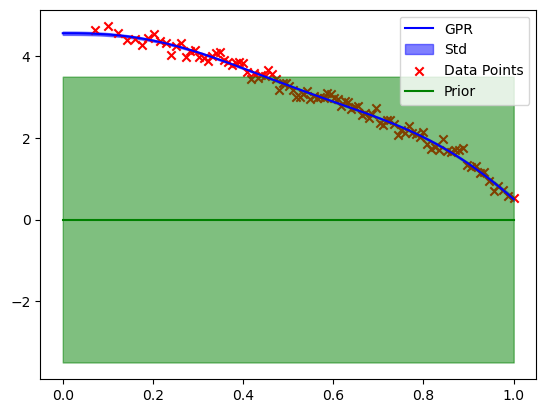

In [20]:
import numpy as np
import logging
from scipy.linalg import inv, cholesky, cho_solve, solve_triangular
from scipy.optimize import minimize

logger = logging.getLogger('lgi')


class GPR(object):
    def __init__(self, x_train, y_train, x_deriv_train=None, y_deriv_train=None,
                 y_train_noise=None, y_deriv_train_noise=None):
        if x_train is None or y_train is None:
            self.x_train = np.array([])
            self.y_train = np.array([])
        else:
            self.x_train = x_train
            self.y_train = y_train
        if x_deriv_train is None or y_deriv_train is None:
            self.x_deriv_train = np.array([])
            self.y_deriv_train = np.array([])
        else:
            self.x_deriv_train = x_deriv_train
            self.y_deriv_train = y_deriv_train
        self.y_train_full = np.hstack([self.y_train, self.y_deriv_train])
        if y_train_noise is None:
            y_train_noise = np.zeros_like(y_train)
        if y_deriv_train_noise is None:
            y_deriv_train_noise = np.zeros_like(y_deriv_train)
        self.cov_d = np.diag(np.hstack((y_train_noise**2,
                                        y_deriv_train_noise**2)))
        self.hypers = {'sigma_f': 1.0,
                       'sigma_l': 0.5}
        self.Kstst = None
    def get_cov(self):
        """
        Squared exponential kernel
        """
        K_n_n = self.hypers['sigma_f'] ** 2 * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - self.x_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        self.K_n_n = K_n_n
        K_n_p = self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (self.x_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_p_n = K_n_p.T
        K_p_p = self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (1 - (self.x_deriv_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2) * \
                np.exp(- 0.5 * (self.x_deriv_train[:, np.newaxis] - self.x_deriv_train[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K = np.block([[K_n_n, K_n_p],
                      [K_p_n, K_p_p]]) + self.cov_d
        K[np.diag_indices_from(K)] += 1e-8
        return K
    
    
    def get_cov_star(self, x_test):
        K_n_t = self.hypers['sigma_f'] ** 2 * \
                np.exp(- 0.5 * (self.x_train[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K_p_t = - self.hypers['sigma_f'] ** 2 / self.hypers['sigma_l'] ** 2 * \
                (self.x_deriv_train[:, np.newaxis] - x_test[np.newaxis, :]) * \
                np.exp(- 0.5 * (self.x_deriv_train[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        print('kst forming', K_n_t.shape, K_p_t.shape)
        return np.block([[K_n_t], [K_p_t]])

    def get_cov_star_star(self, x_test):
        K = self.hypers['sigma_f'] ** 2 * np.exp(- 0.5 * (x_test[:, np.newaxis] - x_test[np.newaxis, :]) ** 2 / self.hypers['sigma_l'] ** 2)
        K[np.diag_indices_from(K)] += 1e-8
        self.Kstst = K
        return K
    
    def get_Kstst(self):
        return self.Kstst

    def set_hypers(self, hypers):
        self.hypers['sigma_f'] = hypers[0]
        self.hypers['sigma_l'] = hypers[1]

    def get_loss(self, hypers):
        self.set_hypers(hypers)
        K = self.get_cov()
        try:
            L = cholesky(K, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf
        # compute the loss
        v = solve_triangular(L, self.y_train_full, lower=True, check_finite=False)
        loss = 2 * np.log(np.diag(L)).sum() + v.T @ v
        logger.debug(f"{['{:.2f}'.format(x) for x in hypers]}: {loss:.2f}")
        return loss

    def fit(self):
        x0 = np.array([self.hypers['sigma_f'], self.hypers['sigma_l']])
        result = minimize(fun=self.get_loss, x0=x0)
        hypers_opt = result.x
        self.hypers['sigma_f'] = hypers_opt[0]
        self.hypers['sigma_l'] = hypers_opt[1]
        print(f"sigma_f = {self.hypers['sigma_f']:.2f}")
        print(f"sigma_l = {self.hypers['sigma_l']:.2f}")

    def predict(self, x_test):
        K = self.get_cov()
        try:
            L = cholesky(K, lower=True, check_finite=False)
        except np.linalg.LinAlgError as exc:
            exc.args = (
                           "The kernel is not returning a positive "
                           "definite matrix.",
                       ) + exc.args
            raise
        K_star = self.get_cov_star(x_test)
        print(K_star.shape)
        K_star_star = self.get_cov_star_star(x_test)
        alpha = cho_solve((L, True), self.y_train_full, check_finite=False)
        y_star = K_star.T @ alpha
        v = solve_triangular(L, K_star, lower=True, check_finite=False)
        cov_star = K_star_star - v.T @ v
        post_mean = y_star
        post_cov = cov_star
        return post_mean, post_cov
    
if __name__ == '__main__':
    def y_fun(x, noise_sigma=0.0):
        x = np.asarray(x)
        y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape)
        return y

    x_train = refl_rho#np.array([1, 3, 4, 5, 9])
    y_train = refl_ne#y_fun(x_train, noise_sigma=1e-4)
    x_deriv_train = xd_prime#np.array([0.0, 2 * np.pi])
    y_deriv_train = yd_prime#np.array([0.0, 0.0])
    x_test = np.linspace(0, 1, 1000)
    gpr = GPR(x_train, y_train, x_deriv_train, y_deriv_train, y_train_noise=yd_noise, 
              y_deriv_train_noise=yd_prime_noise)
    gpr.fit()
    y_test, cov_test = gpr.predict(x_test)
    std = np.sqrt(np.diag(cov_test))
    y_lower = y_test - std
    y_upper = y_test + std
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_test, y_test, 'b-',label='GPR')
    ax.fill_between(x_test, y_lower, y_upper, color='blue', alpha=0.5, label='Std')
    ax.scatter(x_train, y_train, color='red', marker='x',label='Data Points')
    #plot prior
    Kstst = gpr.get_Kstst()
    ax.plot(x_test,np.zeros(len(x_test)),label='Prior',color='g')
    prior_upper = np.zeros(len(x_test)) + np.sqrt(np.diag(Kstst))
    prior_lower = np.zeros(len(x_test)) - np.sqrt(np.diag(Kstst))
    ax.fill_between(x_test, prior_lower, prior_upper, alpha=0.5, color='g')
    plt.legend()
    fig.show()
    
    

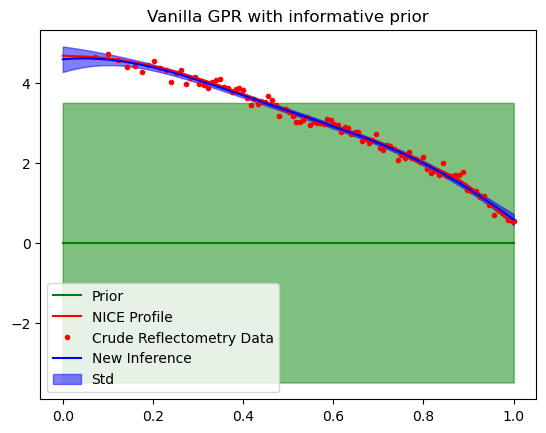

In [71]:
from scipy.linalg import inv, cholesky, cho_solve, solve_triangular
#Informative GP1, Informative vanilla GPR

class InformativeGradientVanillaGPR(object):
    def __init__(self, x_test, xd, yd, yd_noise, prior_mu, prior_cov, xd_prime=None, yd_prime=None, yd_prime_noise=None):
        self.x_test = x_test
        self.xd = xd
        self.yd = yd
        self.yd_noise = yd_noise
        self.prior_mu = prior_mu
        self.prior_cov = prior_cov
        self.xd_prime = xd_prime
        self.yd_prime = yd_prime
        self.yd_prime_noise = yd_prime_noise
        
        self.have_grad = type(self.yd_prime) != type(None) and type(xd_prime)!=type(None) and type(yd_prime_noise)!=type(None) 
        self.post_cov = None
        self.post_mu = None
        self.marge_li = None
        
    def MargeLi(self, cov_D, yd):
        try:
            L = cholesky(cov_D, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf
        # compute the loss
        v = solve_triangular(L, yd, lower=True, check_finite=False)
        marge_li = 2 * np.log(np.diag(L)).sum() + v.T @ v
#         logger.debug(f"{['{:.2f}'.format(x) for x in hypers]}: {loss:.2f}")
        return marge_li
    
    def chol_inv(self, A):
        L = np.linalg.cholesky(A)
        return np.linalg.inv(L).T @ np.linalg.inv(L)
    def InterpolatePrior(self, x1, x2):
        interp = scipy.interpolate.RegularGridInterpolator((self.x_test,x_test), self.prior_cov, method="nearest", bounds_error=True, fill_value=float('nan'))
        X1, X2 = np.meshgrid(x1,x2)
        return interp((X1,X2))
     
    
    def Infer(self):
        Kstst = self.prior_cov
        
        if self.have_grad:
            K_n_n = self.InterpolatePrior(self.xd, self.xd)
            K_p_p = np.gradient(np.gradient(self.InterpolatePrior(self.xd_prime, self.xd_prime), axis=1), axis=0)
            K_n_p = np.gradient(self.InterpolatePrior(self.xd_prime, self.xd), axis=1)#might need correcting
            K_p_n = K_n_p.T
            K = np.block([[K_n_n, K_n_p],
                          [K_p_n, K_p_p]])  
            Kst = np.vstack((self.InterpolatePrior(self.x_test,self.xd), np.gradient(self.InterpolatePrior(self.x_test,self.xd_prime),axis=0)))
            cov_D = K + np.diag(np.hstack((self.yd_noise, self.yd_prime_noise)))
        else:
            K = self.InterpolatePrior(self.xd, self.xd)
            K[np.diag_indices_from(K)] += 1e-8
            Kst = self.InterpolatePrior(self.x_test,self.xd)
            cov_D = K + np.diag(self.yd_noise)

        interp_prior_mu = scipy.interpolate.interp1d(self.x_test, self.prior_mu, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=float('nan'), assume_sorted=False)
        prior_at_xd = interp_prior_mu(self.xd)
        cov_D[np.diag_indices_from(cov_D)] += 1e-8
    
        if self.have_grad:
            prior_at_xd = np.append(prior_at_xd,np.zeros(len(self.xd_prime)))
            yd_full = np.append(self.yd,self.yd_prime)
            self.post_mu = self.prior_mu + Kst.T @ self.chol_inv(cov_D) @ (yd_full - prior_at_xd)
            self.marge_li = self.MargeLi(cov_D, yd_full)
# #     Hao Method
#             try:
#                 L = cholesky(cov_D, lower=True, check_finite=False)
#             except np.linalg.LinAlgError as exc:
#                 exc.args = (
#                                "The kernel is not returning a positive "
#                                "definite matrix.",
#                            ) + exc.args
#                 raise
#             alpha = cho_solve((L, True), yd_full-prior_at_xd, check_finite=False)
#             yst = prior_mu + Kst.T @ alpha
#             self.post_mu = yst

        else: 
            self.post_mu = self.prior_mu + Kst.T @ self.chol_inv(cov_D) @ (self.yd - prior_at_xd)
            self.marge_li = self.MargeLi(cov_D, self.yd)
#         Hao method
#         v = solve_triangular(L, Kst, lower=True, check_finite=False)
#         cov_st = Kstst - v.T @ v
#         self.post_cov = cov_st
        self.post_cov = Kstst - Kst.T @ self.chol_inv(cov_D) @ Kst

    def PlotInference(self):
        std = np.sqrt(np.abs(np.diagonal(self.post_cov)))
        figGPR1 = plt.figure()
        plt.title('Vanilla GPR with informative prior')
        #plot prior
        plt.plot(self.x_test,self.prior_mu,label='Prior',color='g')
        prior_upper = self.prior_mu + np.sqrt(np.diag(self.prior_cov))
        prior_lower = self.prior_mu - np.sqrt(np.diag(self.prior_cov))
        plt.fill_between(self.x_test, prior_lower, prior_upper, alpha=0.5, color='g')
        plt.plot(rho_1d,nice,'r', label='NICE Profile')
        plt.plot(self.xd,self.yd,'r.', label='Crude Reflectometry Data')
        
        plt.plot(self.x_test,self.post_mu,'b', label='New Inference')
        plt.fill_between(x_test, self.post_mu-std, self.post_mu+std, color='b', alpha=0.5, label='Std')
        plt.legend()
        plt.show()

prior_cov = Kstst
infgradvanil = InformativeGradientVanillaGPR(x_test=x_test, xd=refl_rho, yd=refl_ne, yd_noise=yd_noise, prior_mu=prior_mu,
           prior_cov=prior_cov, xd_prime=xd_prime, yd_prime=yd_prime, yd_prime_noise=yd_prime_noise)

infgradvanil.Infer()

infgradvanil.PlotInference()